# Evaluate all perturbation experiments
Using the perturbation wind stresses vs the Bering Strait transport response

In [1]:
from glob import glob
import subprocess
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import warnings
warnings.filterwarnings('ignore')
import numpy as np

## Read in model data
For each experiemnt, load `taux`, `tauy`, and `vmo` for Bering Strait. Integrate the stress over the entire domain and transport across the Bering Strait.

In [2]:
def open_data(exp):
    base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_'
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    
    ## tau data
    # file list
    pp = '/gfdl.ncrc4-intel18-prod/pp/ocean_daily/ts/daily/*yr/'
    flist = (
        glob(f'{base}{exp}{pp}*.taux.nc') + # taux
        glob(f'{base}{exp}{pp}*.tauy.nc') + # tauy
        glob(f'{base}{exp}{pp}../../../ocean_daily.static.nc') # ocean static
    )
    
    # dmget files
    _ = subprocess.run(["dmget"]+flist, check=True)
    
    # open model data
    tD = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
    
    ## vmo data
    # file list
    pp = '/gfdl.ncrc4-intel18-prod/pp/ocean_Bering_Strait/ts/daily/*yr/'
    flist = (glob(f'{base}{exp}{pp}*vmo.nc'))
    
    # dmget files
    _ = subprocess.run(["dmget"]+flist, check=True)
    
    # open model data
    BS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
    
    # Clean up coordinate names
    crds2chng = [match for match in list(BS.coords) if "_sub01" in match]
    for i in crds2chng:
        BS = BS.rename_dims({i:i[:2]}).rename({i:i[:2]})
    
    ## integrate and merge
    # reduce global data to local data
    cond_u = ((tD['geolat_u']>=50)&(tD['geolat_u']<=80)
              &(tD['geolon_u']>=-190)&(tD['geolon_u']<=-150)
              &(tD['wet_u']==1))
    
    cond_v = ((tD['geolat_v']>=50)&(tD['geolat_v']<=80)
              &(tD['geolon_v']>=-190)&(tD['geolon_v']<=-150)
              &(tD['wet_v']==1))
    # initialize dataset
    DS = xr.Dataset()
    # transport
    rho_0 = 1035
    # total transport
    DS['T'] = BS['vmo'].sum(['xh','z_l']).squeeze()/rho_0*(1e-6)
    # y surface force
    DS['Fy'] = (tD['tauy'] * tD['areacello_cv']).where(cond_v,drop=True).sum(['xh','yq'])
    # y surface force
    DS['Fx'] = (tD['taux'] * tD['areacello_cu']).where(cond_u,drop=True).sum(['xq','yh'])
    
    return DS

## Calculate the perturbation response
Calculate the mean and standard deviation of each quantity

In [3]:
def calc_pert(exp):
    # get datasets
    DS = open_data(exp)
    CTRL = open_data('ctrl')
    
    # responses
    for term in list(DS.keys()):
        DS[term + '_r'] = DS[term] - CTRL[term]
    
    # means and stds
    terms = [match for match in list(DS.keys()) if "_r" in match]
    for term in terms:
        DS[term + '_bar'] = DS[term].where(DS.time.dt.month>=3).mean()
        DS[term + '_std'] = DS[term].where(DS.time.dt.month>=3).std()
    
    return DS.load()

In [4]:
# get list of experiments
base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_'
paths = glob(f'{base}*/') 

In [5]:
exps = {
    'v0'    : '68.193_Lx300_Ly500_tau28_v0',
    'v1'    : '68.193_Lx300_Ly500_tau28_v1',
    'v2'    : '68.193_Lx300_Ly500_tau28_v2.5',
    'v5'    : '68.193_Lx300_Ly500_tau28_v5',
    'v10'   : '68.193_Lx300_Ly500_tau28_v10',
    'v20'   : '68.193_Lx300_Ly500_tau28_v20',
    'Lx500' : '68.193_Lx500_Ly500_tau28_v2.5',
    'Ly700' : '68.193_Lx300_Ly700_tau28_v2.5',
    'c66'   : '66.191_Lx300_Ly500_tau28_v10',
    'c64'   : '64.193_Lx300_Ly500_tau28_v10',
    'y1998' : '68.193_Lx300_Ly500_tau28_v10_1998',
    'y2001' : '68.193_Lx300_Ly500_tau28_v10_2001',
    'y2012' : '68.193_Lx300_Ly500_tau28_v10_2012',
    'y2016' : '68.193_Lx300_Ly500_tau28_v10_2016'
}

In [6]:
for exp in list(exps.keys()):
    print(f'{exp} = calc_pert(\'{exps[exp]}\')')
    exec(f'{exp} = calc_pert(\'{exps[exp]}\')')

v0 = calc_pert('68.193_Lx300_Ly500_tau28_v0')
v1 = calc_pert('68.193_Lx300_Ly500_tau28_v1')
v2 = calc_pert('68.193_Lx300_Ly500_tau28_v2.5')
v5 = calc_pert('68.193_Lx300_Ly500_tau28_v5')
v10 = calc_pert('68.193_Lx300_Ly500_tau28_v10')
v20 = calc_pert('68.193_Lx300_Ly500_tau28_v20')
Lx500 = calc_pert('68.193_Lx500_Ly500_tau28_v2.5')
Ly700 = calc_pert('68.193_Lx300_Ly700_tau28_v2.5')
c66 = calc_pert('66.191_Lx300_Ly500_tau28_v10')
c64 = calc_pert('64.193_Lx300_Ly500_tau28_v10')
y1998 = calc_pert('68.193_Lx300_Ly500_tau28_v10_1998')
y2001 = calc_pert('68.193_Lx300_Ly500_tau28_v10_2001')
y2012 = calc_pert('68.193_Lx300_Ly500_tau28_v10_2012')
y2016 = calc_pert('68.193_Lx300_Ly500_tau28_v10_2016')


## Plot relationship between trasport response and stresses
Need to adjust this code to make several different plots all in one loop to be more efficient

In [7]:
colors = [
    'maroon','coral','red','gold',
    'yellowgreen','darkgreen','aquamarine',
    'dodgerblue','mediumblue','blueviolet',
    'violet','deeppink','pink','black','grey'
]

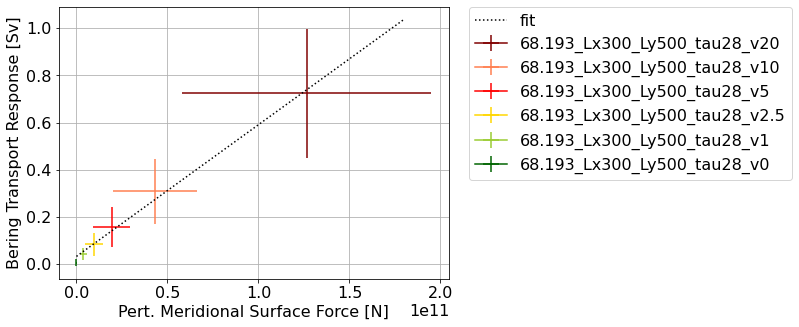

In [8]:
# speed experiments, averages
i=0
x=list()
y=list()
fig = plt.figure(figsize=(7,5))
for exp in ['v20','v10','v5','v2','v1','v0']:
    # add markers to plot
    pltstr = (f'plt.errorbar({exp}[\'Fy_r_bar\'],{exp}[\'T_r_bar\'],' +
              f'xerr={exp}[\'Fy_r_std\'],yerr={exp}[\'T_r_std\'],' +
              f'label=exps[\'{exp}\'],c=colors[{i}])')
    eval(pltstr)
    i += 1
    # get data for linear fit
    eval(f'x.append({exp}[\'Fy_r_bar\'].values)')
    eval(f'y.append({exp}[\'T_r_bar\'].values)')
    
p = np.polyfit(x,y,1,full=True)
plt.plot([0, 1.8e11],np.polyval(p[0],[0, 1.8e11]),':k',label='fit')

plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.ylabel('Bering Transport Response [Sv]')
plt.xlabel('Pert. Meridional Surface Force [N]')
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perYsurfForce_mean_vMagnitude.pdf',bbox_inches='tight')

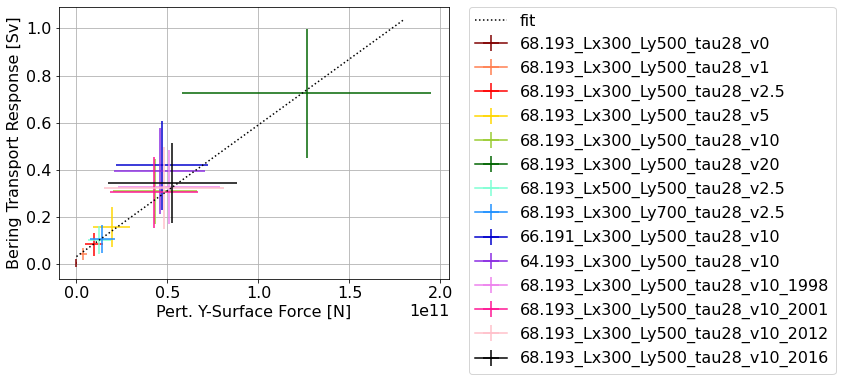

In [9]:
# all experiments, averages
i=0
fig = plt.figure(figsize=(7,5))
for exp in ['v0','v1','v2','v5','v10','v20','Lx500','Ly700',
            'c66','c64','y1998','y2001','y2012','y2016']:
    # add markers to plot
    pltstr = (f'plt.errorbar({exp}[\'Fy_r_bar\'],{exp}[\'T_r_bar\'],' +
              f'xerr={exp}[\'Fy_r_std\'],yerr={exp}[\'T_r_std\'],' +
              f'label=exps[\'{exp}\'],c=colors[{i}])')
    eval(pltstr)
    i += 1

plt.plot([0, 1.8e11],np.polyval(p[0],[0, 1.8e11]),':k',label='fit')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.ylabel('Bering Transport Response [Sv]')
plt.xlabel('Pert. Y-Surface Force [N]')
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perYsurfForce_mean_all.pdf',bbox_inches='tight')

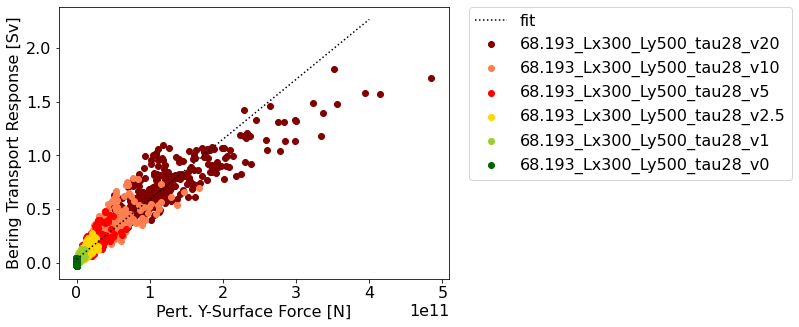

In [10]:
# speed experiments, all daily data
i=0
fig = plt.figure(figsize=(7,5))
for exp in ['v20','v10','v5','v2','v1','v0']:
    pltstr = (f'plt.scatter({exp}[\'Fy_r\'],{exp}[\'T_r\'],' +
              f'label=exps[\'{exp}\'],c=colors[{i}])')
    eval(pltstr)
    i += 1


plt.plot([0, 4e11],np.polyval(p[0],[0, 4e11]),':k',label='fit')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.ylabel('Bering Transport Response [Sv]')
plt.xlabel('Pert. Y-Surface Force [N]')
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perYsurfForce_vMagnitude.pdf',bbox_inches='tight')

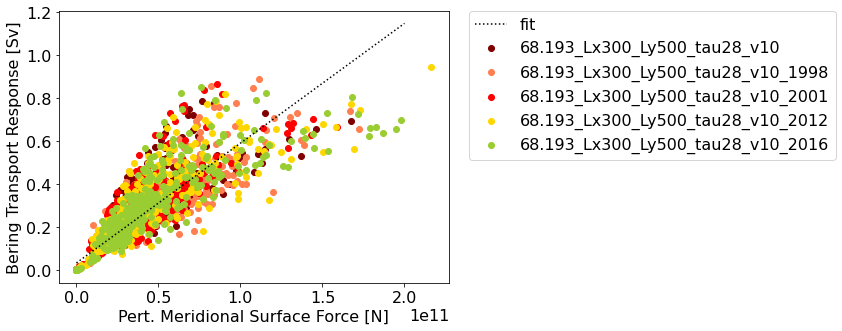

In [11]:
# sea ice experiments, all daily data
i=0
fig = plt.figure(figsize=(7,5))
for exp in ['v10','y1998','y2001','y2012','y2016']:
    pltstr = (f'plt.scatter({exp}[\'Fy_r\'], {exp}[\'T_r\'],' +
              f'label=exps[\'{exp}\'], c=colors[{i}])')
    eval(pltstr)
    i += 1

plt.plot([0, 2e11],np.polyval(p[0],[0, 2e11]),':k',label='fit')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.ylabel('Bering Transport Response [Sv]')
plt.xlabel('Pert. Meridional Surface Force [N]')
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perYsurfForce_Ypert.pdf',bbox_inches='tight')

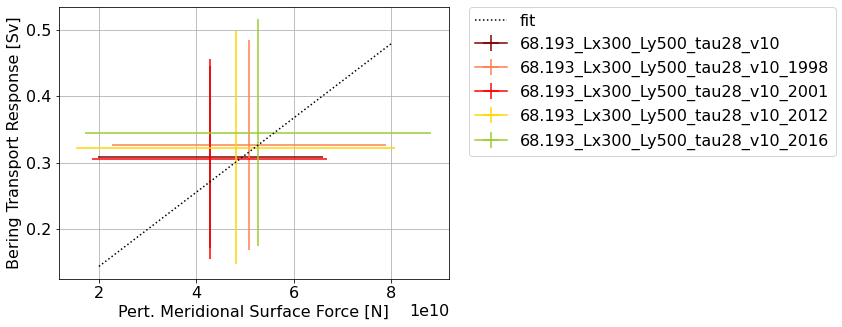

In [12]:
# sea ice experiments, averages
i=0
fig = plt.figure(figsize=(7,5))
for exp in ['v10','y1998','y2001','y2012','y2016']:
    pltstr = (f'plt.errorbar({exp}[\'Fy_r_bar\'],{exp}[\'T_r_bar\'],' +
              f'xerr={exp}[\'Fy_r_std\'],yerr={exp}[\'T_r_std\'],' +
              f'label=exps[\'{exp}\'],c=colors[{i}])')
    eval(pltstr)
    i += 1

plt.plot([2e10, 8e10],np.polyval(p[0],[2e10, 8e10]),':k',label='fit')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.ylabel('Bering Transport Response [Sv]')
plt.xlabel('Pert. Meridional Surface Force [N]')
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perYsurfForce_mean_Ypert.pdf',bbox_inches='tight')